# Notebook for ZFOURGE CDFS Luminosity (Magnitude) Functions Following the SDSS Example

### Import and setup

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM, z_at_value 
import astropy.units as u

data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
df = pd.DataFrame(data)
df = df[df['Use'] == 1] # 13,299
df = df[df['FKs'] > 0] # 12,676

n_lum_bins = 30 # number of luminosity bins
mag_lim = 27 # apparent magnitude limit (same as AB magnitude limit)
redshift_bins = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)] # redshift bins
survey_area = 0.03556 # survey area in square degrees
min_count = 10 # minimum number of galaxies in a bin
all_mag_bins = [30, 25, 25, 20, 15, 10] # number of absolute magnitude bins in each redshift bin

### Ks Band Distributions

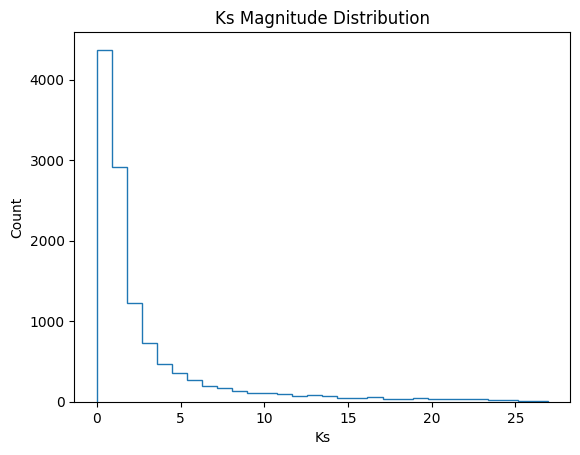

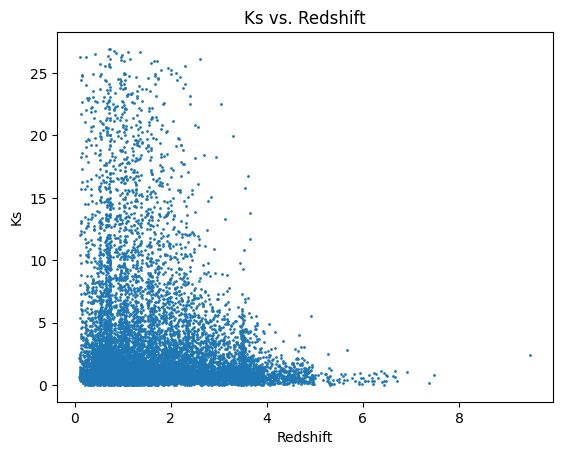

In [153]:
z = df['zpk'] # redshift
mag_app = df['FKs'] # apparent Ks magnitude
mask = (df['FKs'] <= mag_lim)

plt.hist(mag_app[mask], bins=n_lum_bins, histtype='step')
plt.title('Ks Magnitude Distribution')
plt.xlabel('Ks')
plt.ylabel('Count')
plt.show()

plt.scatter(z[mask], mag_app[mask], s=1)
plt.title('Ks vs. Redshift')
plt.xlabel('Redshift')
plt.ylabel('Ks')
plt.show()

### AB Magnitude Distributions

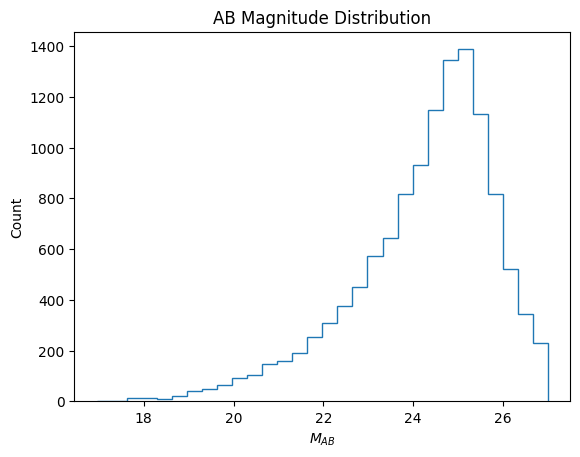

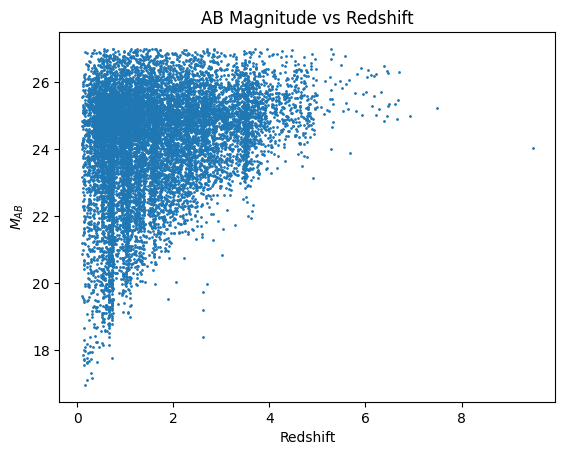

In [154]:
mag_ab = 25 - 2.5*np.log10(mag_app) # apparent magnitude -> AB magnitude
mask = (mag_ab <= mag_lim)

plt.title('AB Magnitude Distribution')
plt.hist(mag_ab[mask], bins=n_lum_bins, histtype='step')
plt.xlabel('$M_{AB}$')
plt.ylabel('Count')
plt.show()

plt.scatter(z[mask], mag_ab[mask], s=1)
plt.title('AB Magnitude vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('$M_{AB}$')
plt.show()

### Absolute Magnitude Distributions

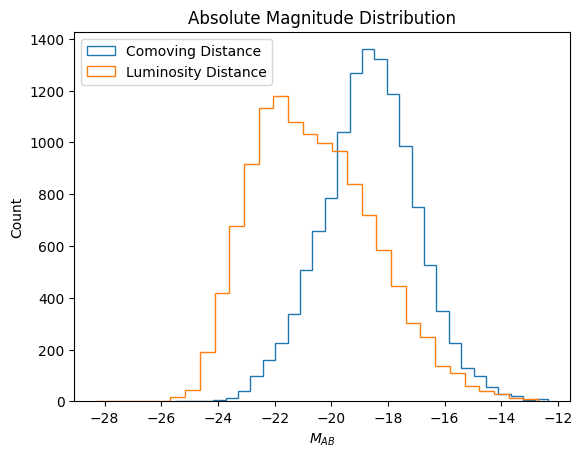

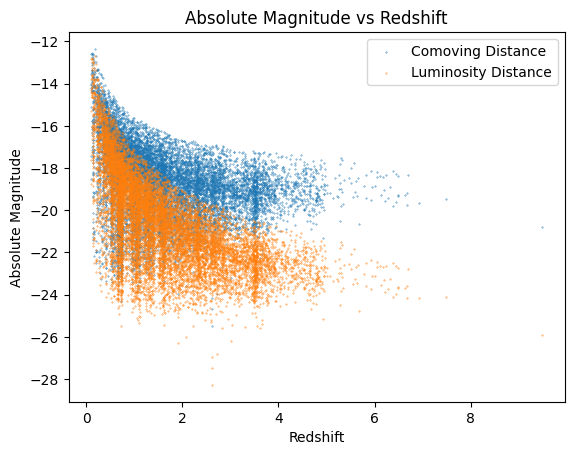

In [155]:
# Cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Absolute Magnitude from luminosity distance
dists = cosmo.luminosity_distance(z) # Mpc
dists *= 10 ** 6 # Mpc -> pc
Mag_abs = mag_ab - 5 * np.log10(dists / 10) # AB magnitude -> absolute magnitude

# Absolute Magnitude from comoving distance
dists_cm = cosmo.comoving_distance(z).value # Mpc
dists_cm *= 10 ** 6 # Mpc -> pc
Mag_abs_cm = mag_ab - 5 * np.log10(dists_cm / 10) # AB magnitude -> absolute magnitude

mask = (mag_ab <= mag_lim) 

plt.title('Absolute Magnitude Distribution')
plt.hist(Mag_abs_cm[mask], bins=n_lum_bins, histtype='step', label='Comoving Distance')
plt.hist(Mag_abs[mask], bins=n_lum_bins, histtype='step', label='Luminosity Distance')
plt.xlabel('$M_{AB}$')
plt.ylabel('Count')
plt.legend()
plt.show()

plt.scatter(z[mask], Mag_abs_cm[mask], s=0.1, label='Comoving Distance')
plt.scatter(z[mask], Mag_abs[mask], s=0.1, label='Luminosity Distance')
plt.title('Absolute Magnitude vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('Absolute Magnitude')
plt.legend()
plt.show()

### Absolute Magnitude Limit vs Redshift

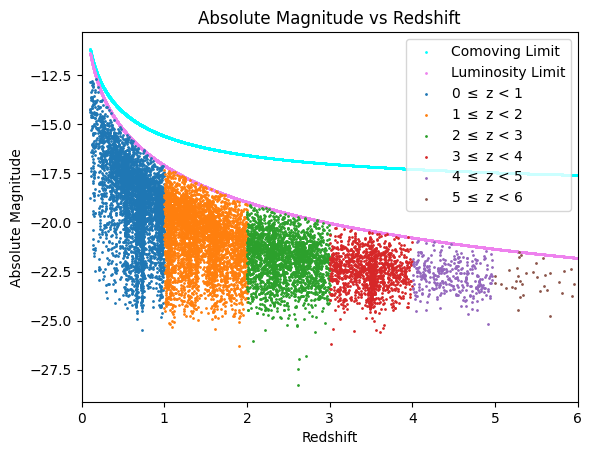

In [156]:
z = z[mask]
Mag_abs = Mag_abs[mask]
dists = dists[mask]

Mag_abs_cm = Mag_abs_cm[mask]
dists_cm = dists_cm[mask]

z_range = np.linspace(z.min(), z.max(), 10000)
M_lim = mag_lim - 5 * np.log10(cosmo.luminosity_distance(z_range).to('pc').value / 10) # luminosity absolute magnitude limit
M_lim_cm = mag_lim - 5 * np.log10(cosmo.comoving_distance(z_range).to('pc').value / 10) # comoving absolute magnitude limit

plt.scatter(z_range, M_lim_cm, s=1, label='Comoving Limit', color='cyan')
plt.scatter(z_range, M_lim, s=1, label='Luminosity Limit', color='violet')
for z_min, z_max in redshift_bins:
    mask = (z >= z_min) & (z < z_max)
    plt.scatter(z[mask], Mag_abs[mask], s=1, label=f'{z_min} $\leq$ z < {z_max}')
plt.title('Absolute Magnitude vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('Absolute Magnitude')
plt.legend()
plt.xlim(0, 6)
plt.show()

def M_abs_lim(z):
    return mag_lim - 5 * np.log10(cosmo.luminosity_distance(z).to('pc').value / 10)

### Absolute Magnitude Bin Limits vs Maximum Redshift

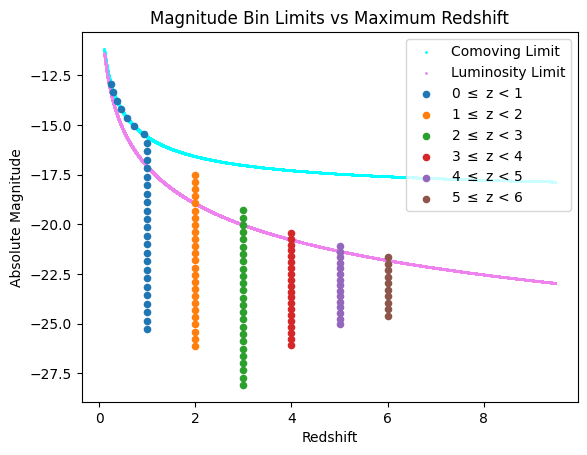

In [157]:
plt.scatter(z_range, M_lim_cm, s=1, label='Comoving Limit', color='cyan')
plt.scatter(z_range, M_lim, s=1, label='Luminosity Limit', color='violet')
for (z_min, z_max), mag_abs_bins in zip(redshift_bins, all_mag_bins):
    mask = (z >= z_min) & (z < z_max)
    
    Mag_abs_bin = Mag_abs[mask]
    
    # Bin the data by luminosity
    counts, lum_bin_edges = np.histogram(Mag_abs_bin, bins=mag_abs_bins)
    lum_bin_centers = lum_bin_edges[0:-1] + (np.diff(lum_bin_edges)[0] / 2)
    
    # Find the maximum distance for the redshift bin
    dmin = cosmo.comoving_distance(z_min).value # Mpc
    dmax = cosmo.comoving_distance(z_max).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = 10 * 10 ** ((mag_lim - lum_bin_centers) / 5) # pc
    dmaxs /= 10 ** 6 # pc -> Mpc
    
    # Only use luminosity bins that are possible in the redshift range
    d_mask = dmaxs >= dmin
    dmaxs = dmaxs[d_mask]
    lum_bin_centers = lum_bin_centers[d_mask]
        
    # Limit the distance to the maximum distance
    dmaxs[dmaxs > dmax] = dmax
    
    # Find the redshift at the maximum distance
    try:
        z_lim = z_at_value(cosmo.comoving_distance, dmaxs * u.Mpc)
    except:
        continue
    plt.scatter(z_lim, lum_bin_centers, s=20, label=f'{z_min} $\leq$ z < {z_max}')
    
plt.title('Magnitude Bin Limits vs Maximum Redshift')
plt.xlabel('Redshift')
plt.ylabel('Absolute Magnitude')
plt.legend(loc='upper right')
plt.show()

### Calculate and save binned counts, volumes, magnitudes, & data

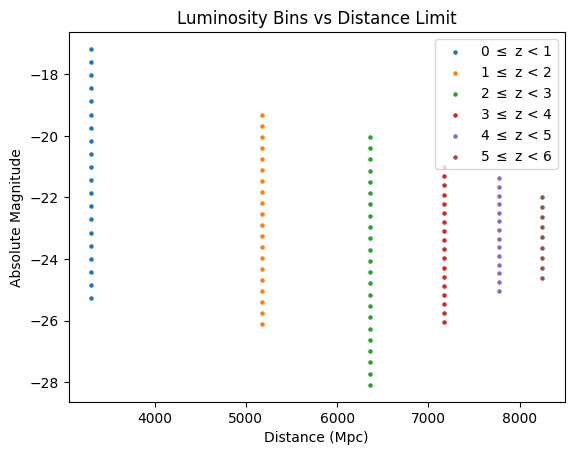

In [158]:
all_data = []

for (z_min, z_max), mag_abs_bins in zip(redshift_bins, all_mag_bins):
    mask = (z >= z_min) & (z < z_max)
    
    Mag_abs_bin = Mag_abs[mask]
    
    # Bin the data by luminosity
    counts, lum_bin_edges = np.histogram(Mag_abs_bin, bins=mag_abs_bins)
    lum_bin_centers = lum_bin_edges[0:-1] + (np.diff(lum_bin_edges)[0] / 2)
    
    # Calculate the minimum and maximum distance of the redshift bin
    dmin = cosmo.comoving_distance(z_min).value # Mpc
    dmax = cosmo.comoving_distance(z_max).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = 10 * 10 ** ((mag_lim - lum_bin_centers) / 5) # pc
    dmaxs /= 10 ** 6 # pc -> Mpc
    
    # Distances must be greater than the minimum distance
    d_mask = dmaxs >= dmin
    
    # Lumiosity bins must be less than or equal to the maximum absolute magnitude
    m = M_abs_lim(z_max)
    mlim_mask = lum_bin_centers <= m
    
    # Apply masks
    dmaxs = dmaxs[d_mask & mlim_mask]
    counts = counts[d_mask & mlim_mask]
    lum_bin_centers = lum_bin_centers[d_mask & mlim_mask]
    
    # If the maximum distance is greater than the maximum redshift bin distance, set it to the maximum redshift bin distance
    dmaxs[dmaxs > dmax] = dmax
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each luminosity bin
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    all_data.append([counts, vol, lum_bin_centers, Mag_abs_bin])
    
    plt.scatter(dmaxs, lum_bin_centers, s=5, label=f'{z_min} $\leq$ z < {z_max}')    

plt.title('Luminosity Bins vs Distance Limit')
plt.xlabel('Distance (Mpc)')
plt.ylabel('Absolute Magnitude')
plt.legend(loc='upper right')
plt.show()

### Counts Histograms

`Mask Threshold` shows the threshold at which magnitude bins will be masked based on the minimum count when the luminosity function is calculated. This is defined in the import and setup cell as `min_count`

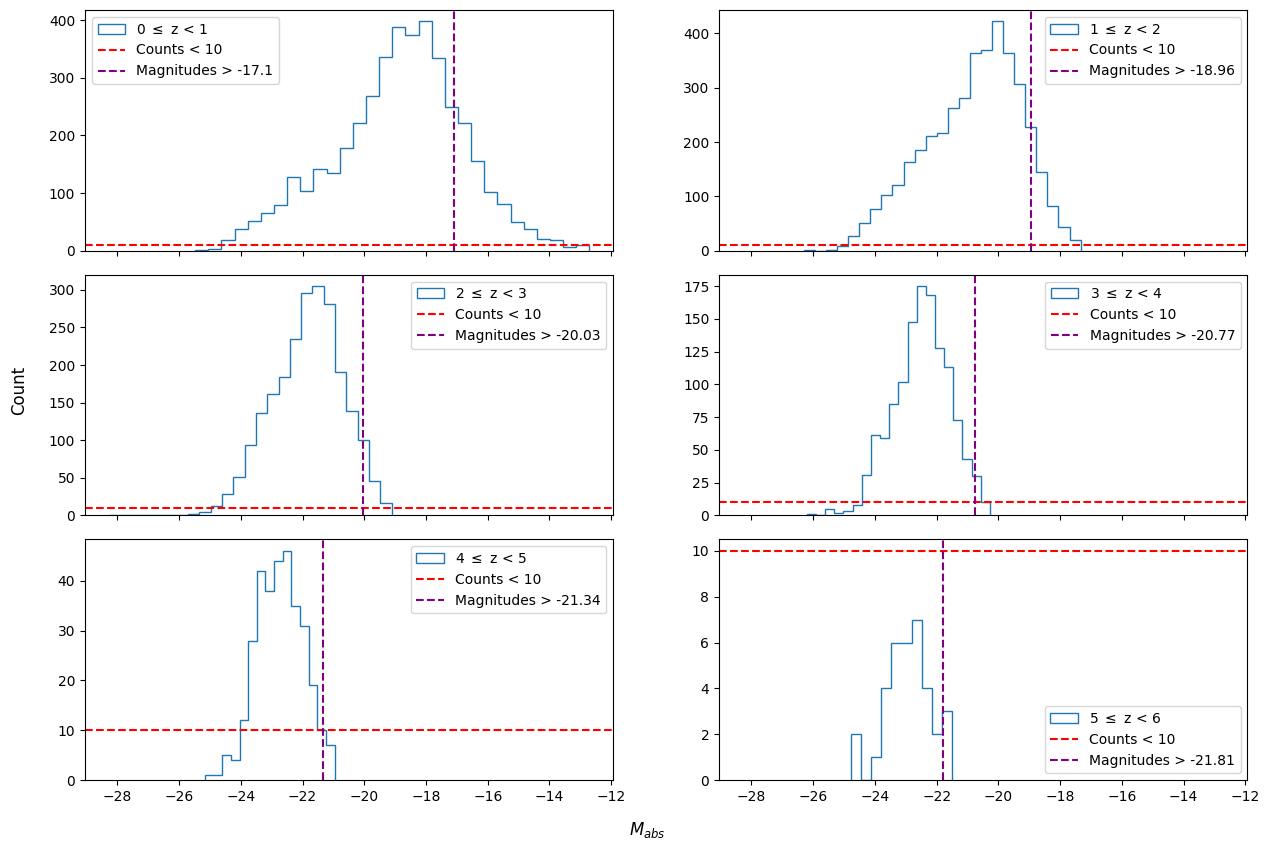

In [159]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True)
for ax, d, (z_start, z_end), mag_abs_bins in zip(axes.flatten(), all_data, redshift_bins, all_mag_bins):
    _, _, _, binned_data = d
    
    # Plot the data
    ax.hist(binned_data, bins=mag_abs_bins, histtype='step', label=f'{z_start} $\leq$ z < {z_end}')
    ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}')
    m = M_abs_lim(z_end)
    ax.axvline(m, color='purple', linestyle='--', label=f'Magnitudes > {round(m, 2)}')
    ax.legend()

fig.supxlabel('$M_{abs}$', y=0.05)
fig.supylabel('Count', x=0.075)
plt.subplots_adjust(hspace=0.1)
plt.show()

### Volume Plots

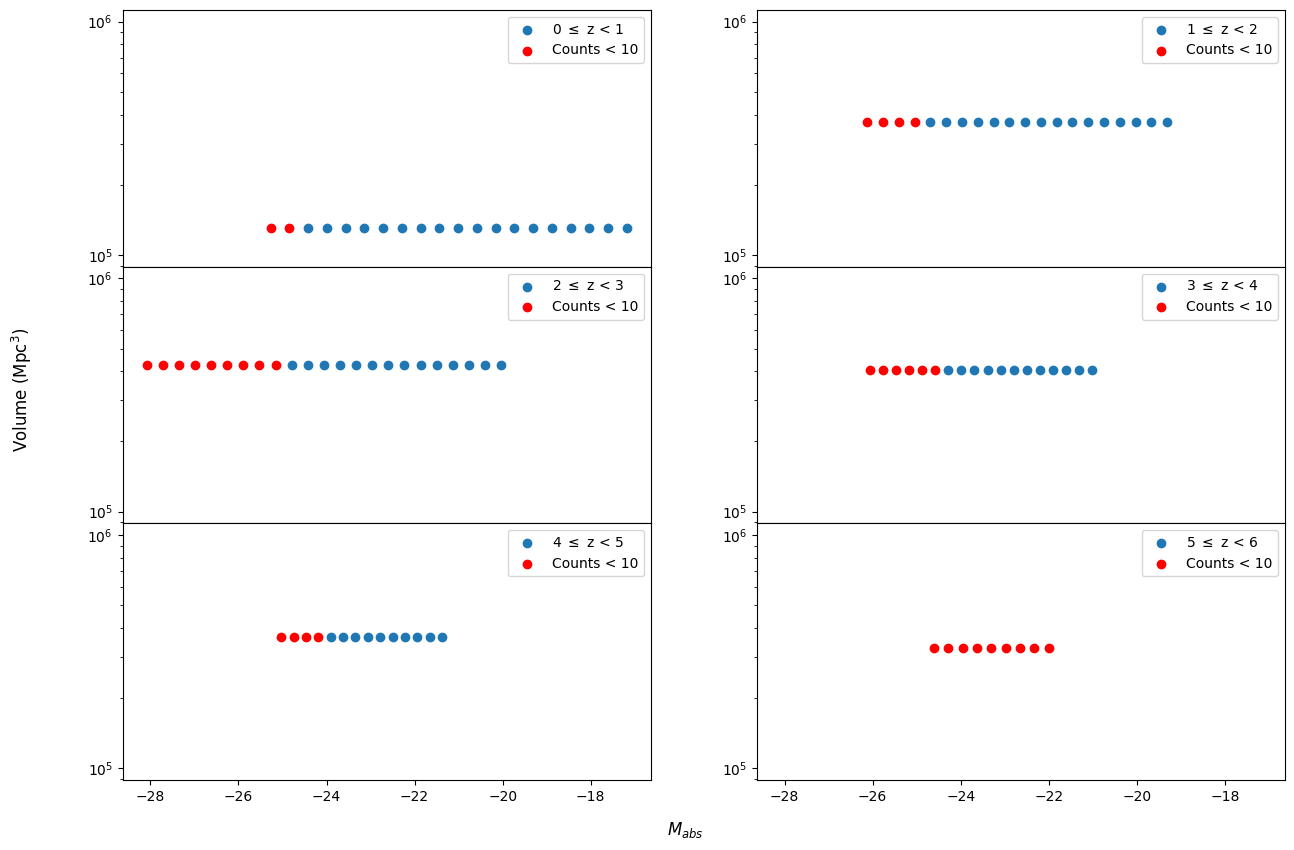

In [160]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True)
for ax, d, (z_start, z_end) in zip(axes.flatten(), all_data, redshift_bins):
    counts, volume, lum_bin_centers, _ = d
    if len(lum_bin_centers) == 0:
        continue
    
    # Mask the data
    good_counts = (counts >= min_count)
    bad_counts = (counts < min_count)
    
    # Plot the data
    ax.scatter(lum_bin_centers[good_counts], volume[good_counts], label=f'{z_start} $\leq$ z < {z_end}')
    ax.scatter(lum_bin_centers[bad_counts], volume[bad_counts], color='red', label=f'Counts < {min_count}')
    ax.set_yscale('log')
    ax.legend()
    
fig.supxlabel('$M_{abs}$', y=0.05)
fig.supylabel('Volume (Mpc$^3$)', x=0.05)
plt.subplots_adjust(hspace=0)
plt.show()

### Luminosity Function

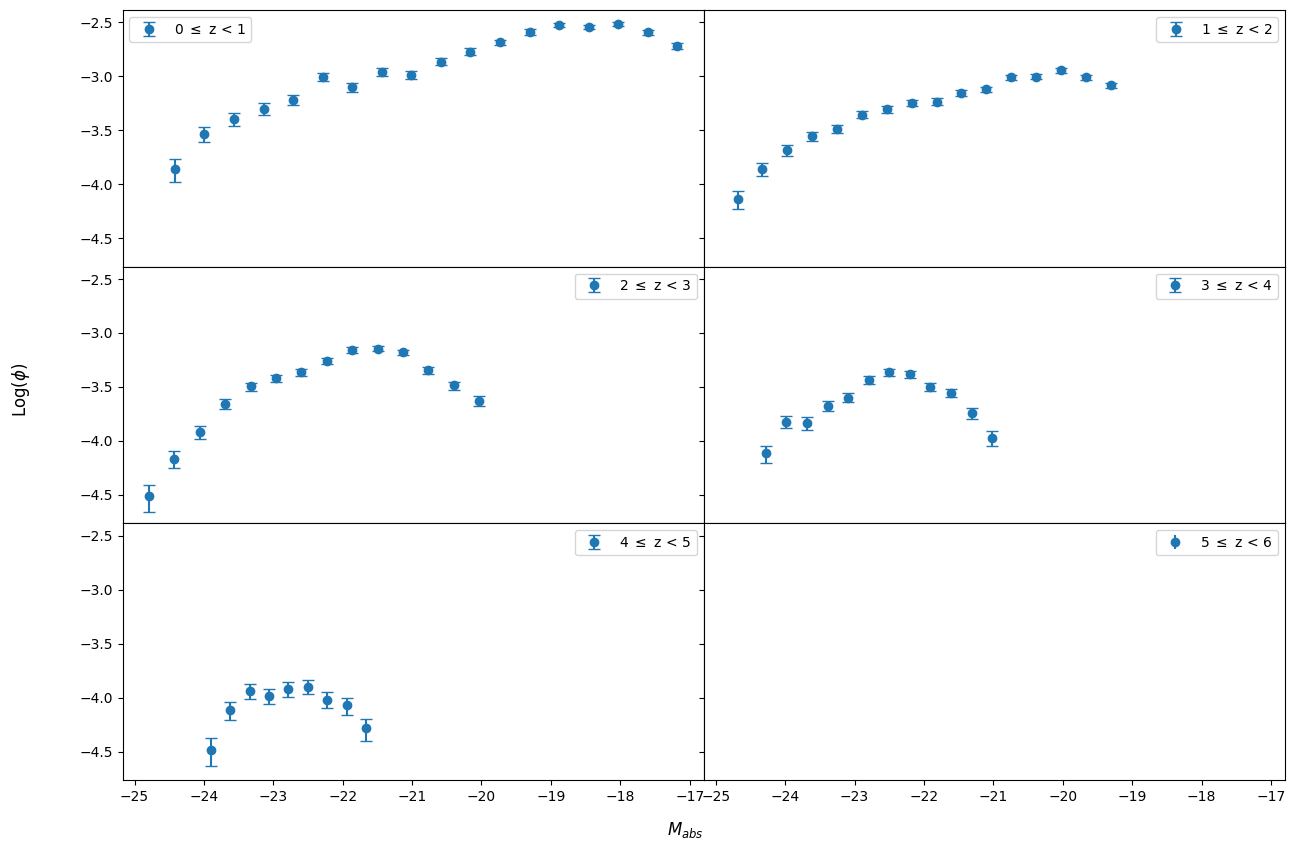

In [161]:
def error(counts, volume):
    upper_counts = counts + np.sqrt(counts)
    lower_counts = counts - np.sqrt(counts)
    
    upper_phi = upper_counts / volume
    lower_phi = lower_counts / volume
    return upper_phi, lower_phi

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for ax, d, (z_start, z_end) in zip(axes.flatten(), all_data, redshift_bins):
    counts, volume, lum_bin_centers, _ = d
    
    # Mask the data
    mask = (counts > min_count)
    counts = counts[mask]
    volume = volume[mask]
    lum_bin_centers = lum_bin_centers[mask]
    
    # Calculate the error
    phi = counts / volume
    upp_phi, low_phi = error(counts, volume)
    yerr = [(np.log10(phi) - np.log10(low_phi)), (np.log10(upp_phi) - np.log10(phi))]
    
    # Plot the data
    ax.errorbar(lum_bin_centers, np.log10(phi), yerr=yerr, fmt='o', label=f'{z_start} $\leq$ z < {z_end}', capsize=4)
    ax.legend()

fig.supxlabel('$M_{abs}$', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Schechter Fit

C:\Users\danie\AppData\Local\Temp\ipykernel_11540\3606468302.py:2: RuntimeWarning: overflow encountered in power
  return phi_star * 10 ** (-0.4*(1-alpha)*(M-M_star)) * np.exp(-10.**(-0.4*(M-M_star)))


0 <= z < 1 Function fit:
M_star = -2.23e+01
phi_star = 1.85e-03
alpha = 1.09e+00


1 <= z < 2 Function fit:
M_star = -2.36e+01
phi_star = 6.95e-04
alpha = 1.10e+00


2 <= z < 3 Function fit:
M_star = -2.24e+01
phi_star = 1.64e-03
alpha = 3.14e-01


3 <= z < 4 Function fit:
M_star = -2.22e+01
phi_star = 1.00e-03
alpha = -3.72e-01


4 <= z < 5 Function fit:
M_star = -2.23e+01
phi_star = 2.75e-04
alpha = -7.06e-01


No data for 5 <= z < 6


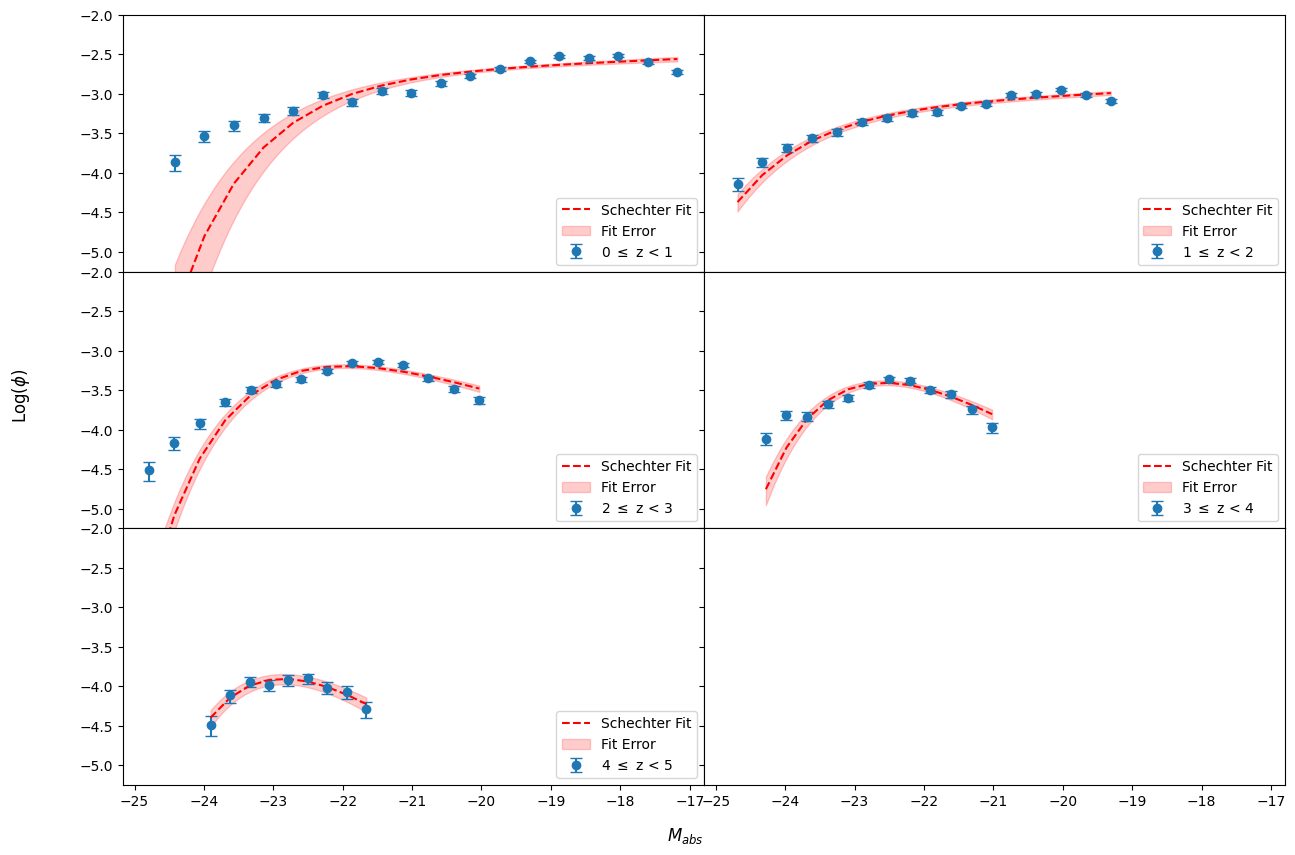

In [162]:
def schechter_magnitude(M, M_star, phi_star, alpha):
    return phi_star * 10 ** (-0.4*(1-alpha)*(M-M_star)) * np.exp(-10.**(-0.4*(M-M_star)))

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for ax, d, (z_start, z_end) in zip(axes.flatten(), all_data, redshift_bins):
    counts, volume, lum_bin_centers, _ = d
    
    # Mask the data
    mask = (counts > min_count) & (volume > 0)
    counts = counts[mask]
    volume = volume[mask]
    lum_bin_centers = lum_bin_centers[mask]
    
    # Calculate phis
    phi = counts / volume
    upp_phi, low_phi = error(counts, volume)
    yerr = [(np.log10(phi) - np.log10(low_phi)), (np.log10(upp_phi) - np.log10(phi))]
    
    if len(lum_bin_centers) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        continue
    
    # Attempt to fit the data
    p0=[lum_bin_centers[0], 0.001, -0.9]
    try:
        params, covars = curve_fit(schechter_magnitude, lum_bin_centers, phi, p0=p0, maxfev=10000)
        upp_params, _ = curve_fit(schechter_magnitude, lum_bin_centers, upp_phi, p0=p0, maxfev=10000)
        low_params, _ = curve_fit(schechter_magnitude, lum_bin_centers, low_phi, p0=p0, maxfev=10000)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum_bin_centers)}.')
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'M_star = {params[0]:.2e}')
    print(f'phi_star = {params[1]:.2e}')
    print(f'alpha = {params[2]:.2e}')
    print('\n')
    
    # Plot the data
    ax.errorbar(lum_bin_centers, np.log10(phi), yerr=yerr, fmt='o', label=f'{z_start} $\leq$ z < {z_end}', capsize=4)
    ax.plot(lum_bin_centers, np.log10(schechter_magnitude(lum_bin_centers, *params)), color='red', label='Schechter Fit', linestyle='--')
    
    long_lum_smooth = np.linspace(lum_bin_centers[0], lum_bin_centers[-1], 100)
    ax.fill_between(long_lum_smooth, 
        np.log10(schechter_magnitude(long_lum_smooth, *low_params)), 
        np.log10(schechter_magnitude(long_lum_smooth, *upp_params)), 
        alpha=0.2, color='red', label='Fit Error')
    
    ax.set_ylim(-5.25, -2)
    ax.legend(loc='lower right')

fig.supxlabel('$M_{abs}$', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Saunders Fit

C:\Users\danie\AppData\Local\Temp\ipykernel_11540\1440976006.py:2: RuntimeWarning: overflow encountered in power
  return phi_star * 10 ** (-0.4*(1-alpha)*(M-M_star)) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + 10 ** (-0.4 * (M - M_star))))**2)


0 <= z < 1 Function fit:
M_star = -1.45e+01
phi_star = 6.95e-04
alpha = 1.97e-01
sigma = 9.02e-01


1 <= z < 2 Function fit:
M_star = -1.62e+01
phi_star = 2.62e-04
alpha = 1.99e-01
sigma = 8.89e-01


2 <= z < 3 Function fit:
M_star = -1.72e+01
phi_star = 9.09e-07
alpha = -2.26e+00
sigma = 4.86e-01


3 <= z < 4 Function fit:
M_star = -1.80e+01
phi_star = 6.20e-09
alpha = -4.57e+00
sigma = 3.69e-01


4 <= z < 5 Function fit:
M_star = -2.30e+01
phi_star = 3.98e-04
alpha = -3.66e-01
sigma = 1.95e-01


No data for 5 <= z < 6


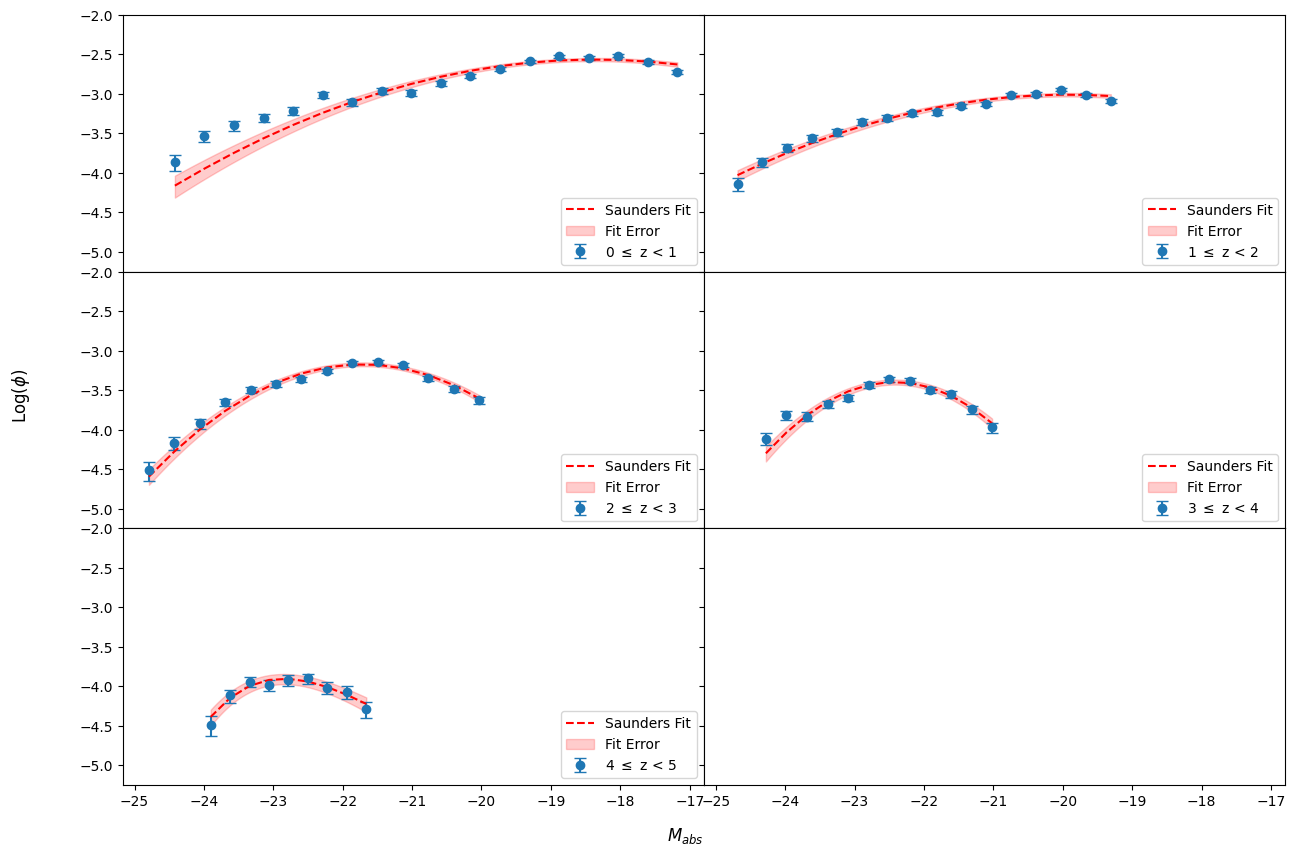

In [163]:
def saunders_magnitude(M, M_star, phi_star, alpha, sigma):
    return phi_star * 10 ** (-0.4*(1-alpha)*(M-M_star)) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + 10 ** (-0.4 * (M - M_star))))**2)

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for ax, d, (z_start, z_end) in zip(axes.flatten(), all_data, redshift_bins):
    counts, volume, lum_bin_centers, _ = d
    
    # Mask the data
    mask = (counts > min_count) & (volume > 0)
    counts = counts[mask]
    volume = volume[mask]
    lum_bin_centers = lum_bin_centers[mask]
    
    # Calculate phis
    phi = counts / volume
    upp_phi, low_phi = error(counts, volume)
    yerr = [(np.log10(phi) - np.log10(low_phi)), (np.log10(upp_phi) - np.log10(phi))]
    
    if len(lum_bin_centers) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        continue
    
    # Attempt to fit the data
    p0 = [lum_bin_centers[0], 0.001, -0.9, 0.1]
    try:
        params, covars = curve_fit(saunders_magnitude, lum_bin_centers, phi, p0=p0, maxfev=10000)
        upp_params, _ = curve_fit(saunders_magnitude, lum_bin_centers, upp_phi, p0=p0, maxfev=10000)
        low_params, _ = curve_fit(saunders_magnitude, lum_bin_centers, low_phi, p0=p0, maxfev=10000)
    except:
        print(f'Failed to fit {z_start} <= z < {z_end}')
        continue        
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'M_star = {params[0]:.2e}')
    print(f'phi_star = {params[1]:.2e}')
    print(f'alpha = {params[2]:.2e}')
    print(f'sigma = {params[3]:.2e}')
    print('\n')
    
    # Plot the data
    ax.errorbar(lum_bin_centers, np.log10(phi), yerr=yerr, fmt='o', label=f'{z_start} $\leq$ z < {z_end}', capsize=4)
    ax.plot(lum_bin_centers, np.log10(saunders_magnitude(lum_bin_centers, *params)), color='red', label='Saunders Fit', linestyle='--')
    
    # Plot the error
    long_lum_smooth = np.linspace(lum_bin_centers[0], lum_bin_centers[-1], 100)
    ax.fill_between(long_lum_smooth, 
        np.log10(saunders_magnitude(long_lum_smooth, *low_params)), 
        np.log10(saunders_magnitude(long_lum_smooth, *upp_params)), 
        alpha=0.2, color='red', label='Fit Error')
    
    ax.set_ylim(-5.25, -2)
    ax.legend(loc='lower right')

fig.supxlabel('$M_{abs}$', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()